In [16]:
import glob
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import scripts.utils as utils

from sklearn import preprocessing
import sklearn.metrics as metric
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix



In [2]:
features_folder = 'data/slices/features'

all_files = glob.glob(features_folder + "/*.csv")

li = []
data_dict = dict()
exploded_data_dict = dict()

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    name = filename.split('/')[-1].split('.')[0]
    df['Dataset'] =  name
    df['instrument'] = df.apply(lambda row : utils.sort_string_elements(row['instrument']), axis = 1)
    df = df[df.instrument != 'rest']
    data_dict[name] = df
    exploded_data_dict[name] = df.drop('instrument', axis=1).join(df['instrument'].str.split('+', expand=True).stack().reset_index(level=1, drop=True).rename('instrument'))
    li.append(df)
    
# concat the list of dataframes in one dataframe
data = pd.concat(li, axis=0, ignore_index=True)
print("Total samples {}".format(len(data.index)))

# Explode/Split column instrument+instrument into multiple rows
exploded_df = data.drop('instrument', axis=1).join(data['instrument'].str.split('+', expand=True).stack().reset_index(level=1, drop=True).rename('instrument'))
print("Total samples exploded {}".format(len(exploded_df.index)))

Total samples 40228
Total samples exploded 70695


In [3]:
# Get Only classes from that are in the MusicSchool subset
data_aux = utils.get_classes_only_in_list_of_datasets(data_dict, ['MusicSchool0', 'MusicSchool1'])
li = []
for key in data_aux:
    li.append(data_aux[key])
data = pd.concat(li, axis=0, ignore_index=True)

instrument_list = np.unique(data['instrument'].to_numpy()).tolist()
#simplest_drumset = ['hh', 'hh+kd', 'hh+kd+sd', 'hh+sd', 'kd', 'kd+sd', 'sd']


data_modif = data.copy()
current_list = np.unique(data_modif['instrument'].to_numpy()).tolist()

data_modif['Dataset_Instrument'] = data_modif['Dataset'] + '::' + data_modif['instrument']

# delete columns with 0 stdev
columns = data_modif.columns[:-3]
stdev0_features = columns[data_modif.std() < 0.00001].to_list()
data_modif = data_modif.drop(stdev0_features, axis = 1)
used_features = data_modif.columns

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(data_modif.iloc[:,:-3].values)
std_scaler = preprocessing.StandardScaler()
X = std_scaler.fit_transform(X)

joblib.dump(min_max_scaler, 'models/minmax.pck')
joblib.dump(std_scaler, 'models/std_scaler.pck')

# separate label from data
y = data_modif.instrument


print('NaNs in the dataframe: ',data_modif.isnull().sum().sum())#sums a matrix of True/False values obtained by checking if each value is Nan

classes = np.unique(data_modif.instrument)
values_list = range(len(classes))
zip_iterator = zip(classes, values_list)
classes_dictionary = dict(zip_iterator)

NaNs in the dataframe:  0


In [4]:
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [-0.22181433  1.01142805 -0.74005192  0.90013184 -0.01079386  0.65732653
 -0.07783081  2.23571229  1.13985192  1.24306353  0.88554628 -0.58392449
 -0.44197755 -0.14543042 -0.34685575 -0.6590952  -0.19743591  0.19127162
 -0.13807195 -0.9275374   0.48985992 -0.39746402  0.36734079 -0.3550631
 -0.38365297 -1.94939451 -0.91128801  0.50301827 -1.09501961  0.34895817
  3.18655844 -0.41783576  1.55402187 -0.01243644  0.5509487   0.0349777
  1.77207339  0.96497698  1.78097796 -0.71030302  0.69592631 -2.27752103
  3.95443354 -1.0441135   1.86726715 -0.95686563  0.11836382  0.67697723
  1.54009587  0.11393337 -1.65388464  1.23865828  3.05462888 -0.40385542
 -0.46276584  1.21254607  2.70571823 -0.39641191 -1.31703865 -0.79504168
 -0.75535387  0.37442767 -0.68956957  1.06580466  2.2064566  -0.36463525
 -0.55253906  0.94987599  2.31630355  0.09615873  0.53710974 -0.34946768
 -0.53756123 -0.21296491 -0.49674036 -0.34749273 -0.14058817  0.21374042
  0.55755804]
Class of

In [5]:
#split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 2)
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (26761, 79) , Size of train output vector:  (26761,)
Size of test features matrix:  (11470, 79) , Size of test output vector:  (11470,)


In [6]:
clf_svc = SVC(C = 10, gamma = 1 / (X_train.shape[-1] * X_train.var()))
clf_svc.fit(X_train, y_train)  
joblib.dump(clf_svc, 'models/SVM.pck') 

['models/SVM.pck']

In [7]:
N_classes = len(np.unique(data_modif['instrument'].to_numpy()).tolist())
clf_knn = KNeighborsClassifier( n_neighbors = N_classes)
clf_knn.fit(X_train, y_train)  
joblib.dump(clf_knn, 'models/KNN.pck')

['models/KNN.pck']

In [8]:
y_pred_svc = clf_svc.predict(X_test)
y_pred_knn = clf_knn.predict(X_test)

SVC
	Balanced accuracy:  0.9468215800961778
	F-score:  0.9471897692252244 



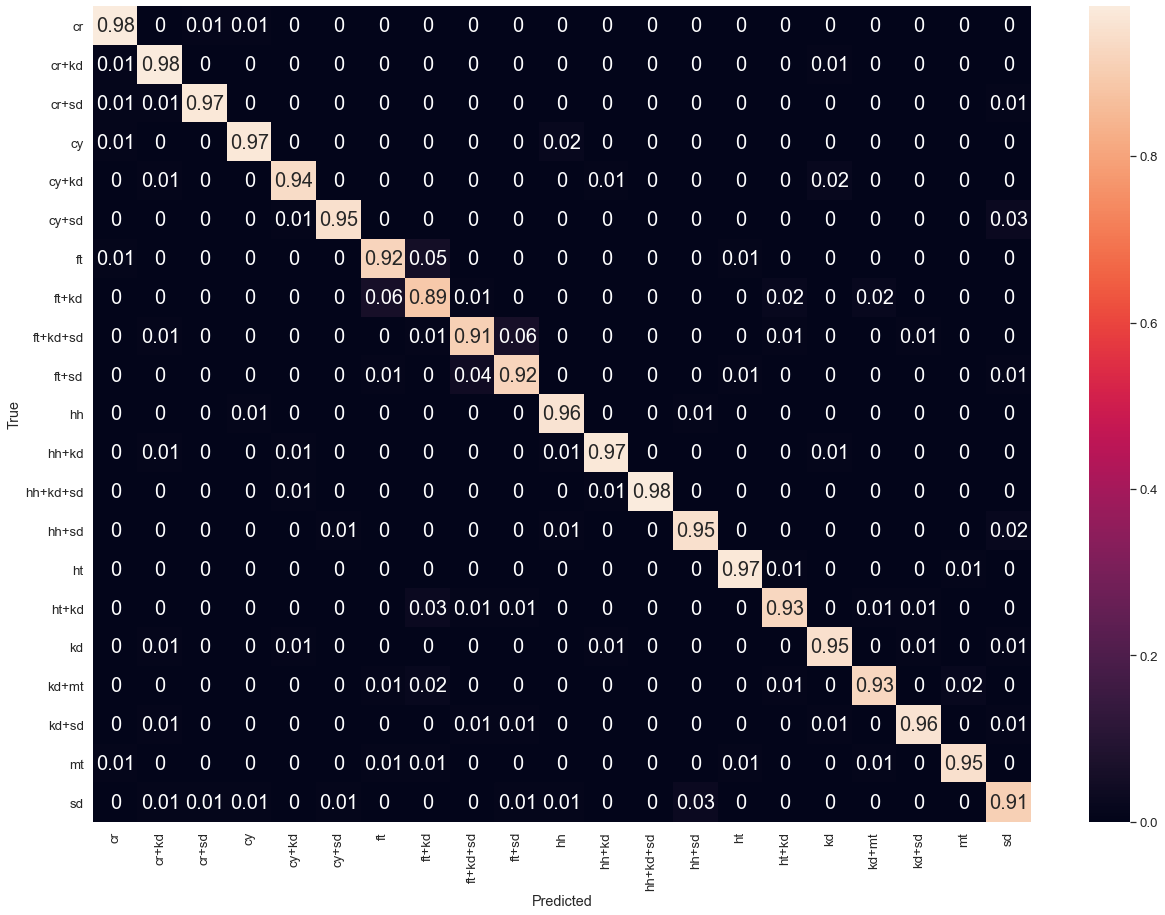

KNN
	Balanced accuracy:  0.7810152642173926
	F-score:  0.7791505854607734 



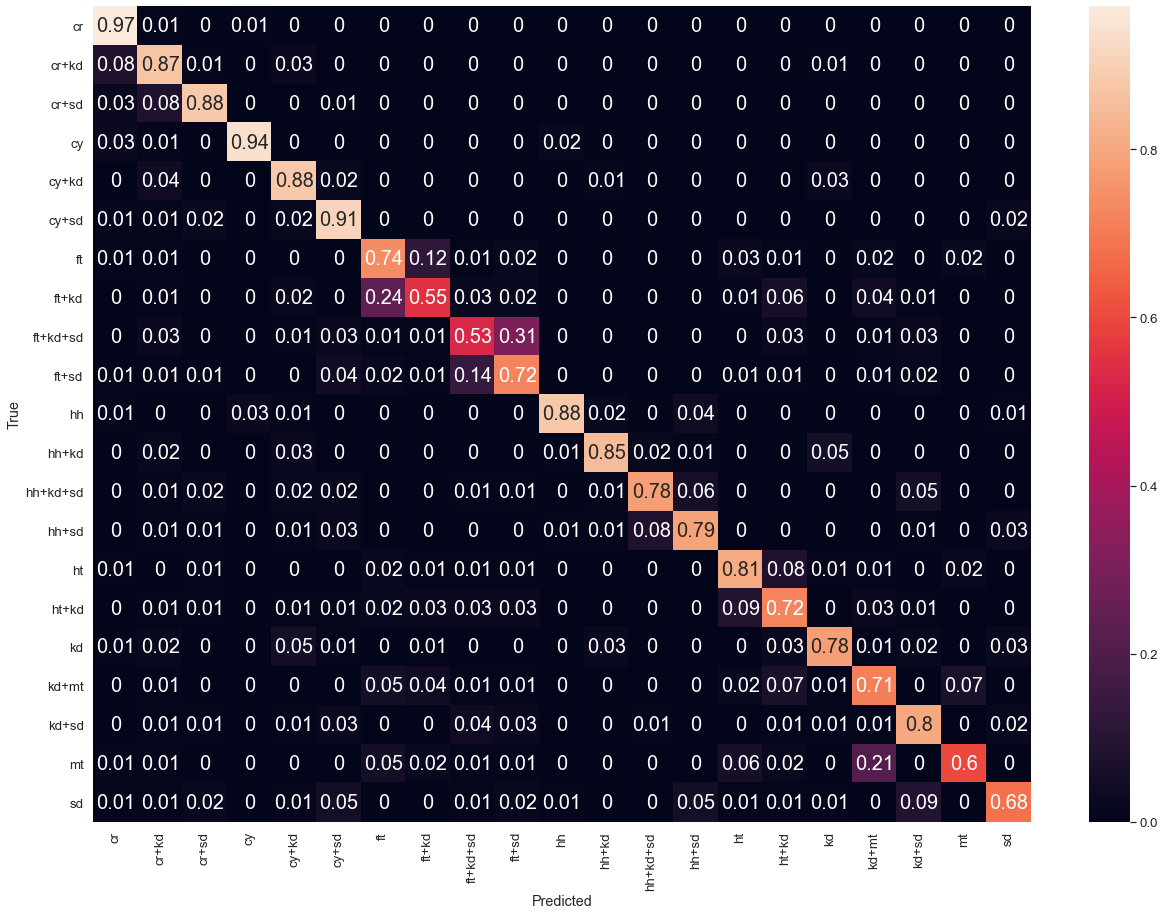

In [18]:
clf_names = ['SVC', 'KNN']
i = 0
for y_pred in [y_pred_svc, y_pred_knn]:
    print(clf_names[i])
    print('\tBalanced accuracy: ', metric.balanced_accuracy_score(y_test, y_pred))
    print('\tF-score: ', metric.f1_score(y_test, y_pred, average = 'weighted'), '\n')
    le = preprocessing.LabelEncoder()
    classes = np.unique(data.instrument)
    data_modif.instrument = le.fit_transform(data_modif.instrument.astype(str))
    values_list = range(len(classes))
    zip_iterator = zip(classes, values_list)
    classes_dictionary = dict(zip_iterator)
    conf_mat = pd.DataFrame(metric.confusion_matrix(y_test, y_pred, normalize = 'true'), columns = classes_dictionary, index = classes_dictionary).round(2)
    conf_mat.index.name = 'True'
    conf_mat.columns.name = 'Predicted'
    plt.figure(figsize = (21,15))
    sns.set(font_scale = 1.2)
    sns.heatmap(conf_mat, annot_kws = {"size": 20}, annot = True);
    plt.show()
    i = i +1